# Symbolic Equations

This notebook sets up the equations for the currents and voltages and the regions of validity.

In [1]:
import sympy 
sympy.init_printing()

In [2]:
# symbols used
Ib = sympy.symbols('I_b', nonnegative=True)
Ic = sympy.symbols('I_c', nonnegative=True)                       # peak 
Vb = sympy.symbols('V_b')
Vc = sympy.symbols('V_c')                                         # peak, phase to neutral
Rm = sympy.symbols('R_m', positive=True)                          # phase to neutral motor resistance
k = sympy.symbols('k', positive=True)                             # phase to phase k in volt-sec/rad
omega = sympy.symbols('omega', positive = True)
Rb = sympy.symbols('R_b', positive=True)
Voc = sympy.symbols('V_oc', positive=True)
Imm = sympy.symbols('I_mm')
Ibm = sympy.symbols('I_bm')
torque = sympy.symbols('tau')

# governing equations
battery_loop = sympy.Eq(Voc, Ib * Rb + Vb)
power_eq = sympy.Eq(Vb * Ib, Vc * Ic)
controller_loop = sympy.Eq(Vc, Ic * Rm + k * omega)
regime_1 = sympy.Eq(Ic, Imm)
regime_2 = sympy.Eq(Ib, Ibm)
regime_3 = sympy.Eq(Vb, Vc)

is_three_phase = True

if is_three_phase == True:
    power_eq = sympy.Eq(Vb * Ib, sympy.Rational(3/2) * Vc * Ic)
    controller_loop = sympy.Eq(Vc, Ic * Rm + k * omega / sympy.sqrt(3))
    regime_3 = sympy.Eq(Vb, sympy.sqrt(3) * Vc)

# numbers for numerical evaluation
ev_system = {Rb: 0.120, Voc:50, Imm: 150, Ibm:100, Rm: 0.128, k:1.0}

# Constant Torque Region

We model the section where the controller is at max motor current by using the regime 1 equation and solving.

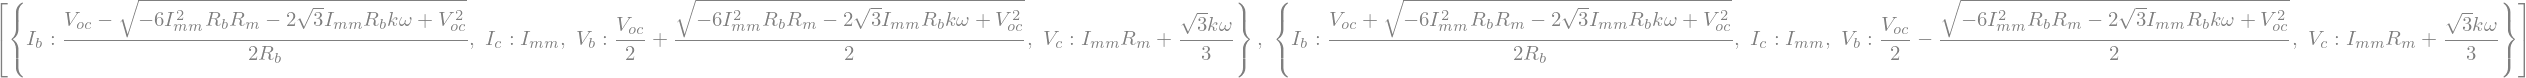

In [3]:
constant_torque = sympy.solve([power_eq, battery_loop, controller_loop, regime_1], exclude=[Rb, Rm, k, Imm, Voc])
constant_torque 

## Selecting Constant Torque Solution

We expect the battery current to increase as omega increases (positive derivative) so we select the first equation.
We see that this derivative is positive but will be imaginary for high motor current or motor speed.

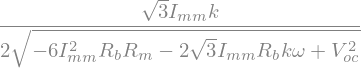

In [4]:
sympy.diff(constant_torque[0][Ib], omega)

## Constant Torque Battery Current

Here is our expression for the battery current.

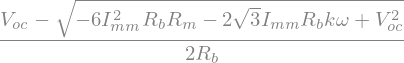

In [5]:
constant_torque[0][Ib]

# Constant Power Region

In the constant power region, the battery current and voltage are constant and we can solve for the controller current and voltage.

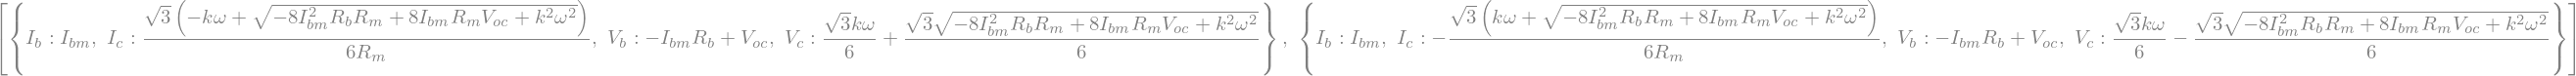

In [6]:
constant_power = sympy.solve([power_eq, battery_loop, controller_loop, regime_2], exclude=[Rb, Rm, k, Ibm, Voc])
constant_power
#sympy.diff(battery_limit[0][Ic], omega) 

## Constant Power Motor Current

We select the equation that has a positive motor current.

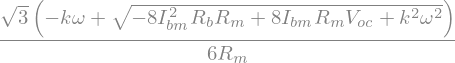

In [7]:
constant_power[0][Ic]

# BEMF Limit Region

At some point, the motor is spinning fast enough that the battery current will fall below maximum.
Above this RPM, the duty cycle will be at max so the controller voltage will equal the battery voltage.
Solving we get the following equations.

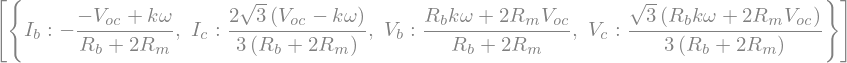

In [8]:
duty_limit = sympy.solve([power_eq, battery_loop, controller_loop, regime_3], exclude=[Rb, Rm, k, Voc])
duty_limit

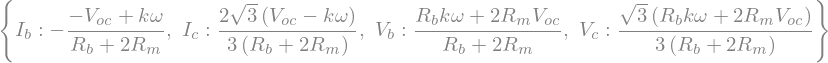

In [9]:
duty_limit[0]

# Crossover Frequencies

Once we determine the motor speeds at which we move from one regime to the other, we can construct a piece-wise solution for the motor and battery currents.

## Transition from Constant Torque to Constant Power

We find the frequency at which we transition from the constant torque to the constant power regime by setting the battery current expression in the constant torque regime equal to the maximum battery current and solving for omega. 

Question: what if you never hit the maximum battery current?

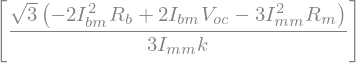

In [14]:
sympy.solve(sympy.Eq(constant_torque[0][Ib], Ibm), omega)

## Transition from Constant Power to BEMF Region

- Set the battery current in the constant power regime to the battery current in the BEMF region.
- Set the motor current in the constant power regime to the motor current in the BEMF region

These two approaches share a solution.


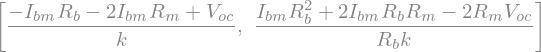

In [11]:
sympy.solve(sympy.Eq(constant_power[0][Ic], duty_limit[0][Ic]), omega)

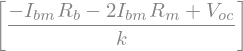

In [12]:
sympy.solve(sympy.Eq(constant_power[0][Ib], duty_limit[0][Ib]), omega)

# No-Load Speed

The no load speed occurs when the battery or controller current reaches zero at the expected frequency of the open-circuit voltage divided by the voltage constant.

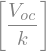

In [13]:
# no load speed is when Ib and Ic = 0, Vb = Voc, and Vc = Voc/sqrt(3)
no_load_speed = sympy.solve(sympy.Eq(duty_limit[0][Ib], 0), omega)
no_load_speed